In [12]:
import seaborn as sns
import matplotlib 

import matplotlib.pyplot as plt


import math
from sys import path
path.append('..//modules')
path.append('..//dumps//reg_dmo_pdf')
import time
import pandas as pd
import psycopg2 as pg
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import create_engine, MetaData, Table
import pandas.io.sql as psql

#create a postgres engine and a pg connection
from modules.db_connector import *
print("DB connecting engine imported")


DB connecting engine imported


In [13]:
with engine.connect() as con1:
    q = """
SELECT * FROM gtlab.sk_sgs_vgl_sguds 
LEFT JOIN (SELECT dmo_id, 'DMO ' || dmo_id nm_dmoid,  dmo_name FROM gtlab.sk_dmos_raw) dmos USING(dmo_id) 
LEFT JOIN (select "gml_id" gml_id_cat1_sk_mchu_sps_sopsr, 'NPR' mchu_cat1,  "SITETITLE_SK" name_cat1_sk_mchu_sps_sopsr from gtlab.sk_mchu_sps_sopsr WHERE "CATEGORY" = 1) spscat1 USING (gml_id_cat1_sk_mchu_sps_sopsr) 
LEFT JOIN (select "gml_id" gml_id_cat2_sk_mchu_sps_sopsr, 'PR' mchu_cat2, "SITETITLE_SK" name_cat2_sk_mchu_sps_sopsr from gtlab.sk_mchu_sps_sopsr WHERE "CATEGORY" = 2) spscat2 USING (gml_id_cat2_sk_mchu_sps_sopsr) 
LEFT JOIN (select "gml_id" gml_id_cat3_sk_mchu_sps_sopsr, 'NPP' mchu_cat3, "SITETITLE_SK" name_cat3_sk_mchu_sps_sopsr from gtlab.sk_mchu_sps_sopsr WHERE "CATEGORY" = 3) spscat3 USING (gml_id_cat3_sk_mchu_sps_sopsr) 
LEFT JOIN (select "gml_id" gml_id_cat4_sk_mchu_sps_sopsr, 'PP' mchu_cat4, "SITETITLE_SK" name_cat4_sk_mchu_sps_sopsr from gtlab.sk_mchu_sps_sopsr WHERE "CATEGORY" = 4) spscat4 USING (gml_id_cat4_sk_mchu_sps_sopsr) 
LEFT JOIN (select "gml_id" gml_id_cat5_sk_mchu_sps_sopsr, 'CHA' mchu_cat5, "SITETITLE_SK" name_cat5_sk_mchu_sps_sopsr from gtlab.sk_mchu_sps_sopsr WHERE "CATEGORY" = 5) spscat5 USING (gml_id_cat5_sk_mchu_sps_sopsr) 	
LEFT JOIN (select "gml_id" gml_id_cat6_sk_mchu_sps_sopsr, 'OP' mchu_cat6, "SITETITLE_SK" name_cat6_sk_mchu_sps_sopsr from gtlab.sk_mchu_sps_sopsr WHERE "CATEGORY" = 6) spscat6 USING (gml_id_cat6_sk_mchu_sps_sopsr) 	
LEFT JOIN (select "SITEID"::text siteid_cat8_sk_vchu_lps_sopsr, "SITETITLE_SK" name_cat8_sk_vchu_lps_sopsr from gtlab.sk_vchu_lps_sopsr WHERE "CATEGORY" = 8) lpscat8 USING (siteid_cat8_sk_vchu_lps_sopsr) 	
LEFT JOIN (select "SITEID"::text siteid_cat9_sk_vchu_lps_sopsr, "SITETITLE_SK" name_cat9_sk_vchu_lps_sopsr from gtlab.sk_vchu_lps_sopsr WHERE "CATEGORY" = 9) lpscat9 USING (siteid_cat9_sk_vchu_lps_sopsr) 	
LEFT JOIN (select "SITEID"::text siteid_cat10_sk_vchu_lps_sopsr, "SITETITLE_SK" name_cat10_sk_vchu_lps_sopsr from gtlab.sk_vchu_lps_sopsr WHERE "CATEGORY" = 10) lpscat10 USING (siteid_cat10_sk_vchu_lps_sopsr) 	
LEFT JOIN (select "SITEID"::text siteid_sk_uev_teui_sopsr, "SITETITLE_SK" name_sk_uev_teui_sopsr from gtlab.sk_uev_teui_sopsr) sk_uev_teui USING (siteid_sk_uev_teui_sopsr) 	
LEFT JOIN (select "SITEID"::text siteid_sk_chvu_bpa_sopsr, "SITETITLE_SK" name_sk_chvu_bpa_sopsr from gtlab.sk_chvu_bpa_sopsr) sk_chvu_bpa USING (siteid_sk_chvu_bpa_sopsr)
""" 	

    df_sgs = pd.read_sql(q, con=con1)
    con1.close()

df_sgs["in_dmo"] = [str(x).replace(str(x), "Within DMO boundaries", 1) if str(x) != 'nan' else str(x).replace(str(x), "Not within DMO boundaries", 1) for x in df_sgs["dmo_id"] ]

df_group_dmo = df_sgs.groupby("nm_dmoid", dropna=True).count()
df_sgs_sorted = df_sgs.copy()
df_sgs_sorted['nm_dmoid'] = pd.Categorical(df_sgs_sorted['nm_dmoid'], list(df_group_dmo.sort_values(by=['objectid'], ascending=False).index))
df_sgs['nm_dmoid'] = df_sgs['nm_dmoid'].fillna(value='NO DMO')


for i, sspaid1, sspaid2, sspaid3, sspaid4, sspaid5, sspaid6, sspaid_cat_nm_penetration in zip(df_sgs.index, df_sgs.gml_id_cat1_sk_mchu_sps_sopsr, df_sgs.gml_id_cat2_sk_mchu_sps_sopsr, df_sgs.gml_id_cat3_sk_mchu_sps_sopsr, df_sgs.gml_id_cat4_sk_mchu_sps_sopsr, df_sgs.gml_id_cat5_sk_mchu_sps_sopsr, df_sgs.gml_id_cat6_sk_mchu_sps_sopsr, df_sgs.category_name_sk_mchu_sps_sopsr_by_name):
    if sspaid1 != None:
        df_sgs.loc[i, 'mchu_cat_name_by_spatial_penetration'] = "National nature reservation"
    elif sspaid2 != None:
        df_sgs.loc[i, 'mchu_cat_name_by_spatial_penetration'] = "Nature reservation"
    elif sspaid3 != None:
        df_sgs.loc[i, 'mchu_cat_name_by_spatial_penetration'] = "National natural monument"
    elif sspaid4 != None:
        df_sgs.loc[i, 'mchu_cat_name_by_spatial_penetration'] = "Natural monument"
    elif sspaid5 != None:
        df_sgs.loc[i, 'mchu_cat_name_by_spatial_penetration'] = "Protected area"
    elif sspaid6 != None:
        df_sgs.loc[i, 'mchu_cat_name_by_spatial_penetration'] = "Protection zone of SSPA"
    else:
        df_sgs.loc[i, 'mchu_cat_name_by_spatial_penetration'] = "Not identified by spatial penetration"
    
for i, sspaid_cat_nm_penetration in zip(df_sgs.index, df_sgs.category_name_sk_mchu_sps_sopsr_by_name):
    if str(sspaid_cat_nm_penetration) == '1':
        df_sgs.loc[i, 'mchu_cat_name_by_name_penetration_dist_test'] = "National nature reservation"
    elif str(sspaid_cat_nm_penetration) == '2':
        df_sgs.loc[i, 'mchu_cat_name_by_name_penetration_dist_test'] = "Nature reservation"
    elif str(sspaid_cat_nm_penetration) == '3':
        df_sgs.loc[i, 'mchu_cat_name_by_name_penetration_dist_test'] = "National natural monument"
    elif str(sspaid_cat_nm_penetration) == '4':
        df_sgs.loc[i, 'mchu_cat_name_by_name_penetration_dist_test'] = "Natural monument"
    elif str(sspaid_cat_nm_penetration) == '5':
        df_sgs.loc[i, 'mchu_cat_name_by_name_penetration_dist_test'] = "Protected area"
    elif str(sspaid_cat_nm_penetration) == '6':
        df_sgs.loc[i, 'mchu_cat_name_by_name_penetration_dist_test'] = "Protection zone of SSPA"
    else:
        df_sgs.loc[i, 'mchu_cat_name_by_name_penetration_dist_test'] = "Not identified by name within 5 km"
        
    
    
for i, sguds_cat in zip(df_sgs.index, df_sgs.typ_mchu):
    if sguds_cat == 'Národná prírodná rezervácia':
        df_sgs.loc[i, 'sspa_cat_sguds_en'] = "National nature reservation"
    elif sguds_cat == 'Prírodná rezervácia':
        df_sgs.loc[i, 'sspa_cat_sguds_en'] = "Nature reservation"
    elif sguds_cat == 'Národná prírodná pamiatka':
        df_sgs.loc[i, 'sspa_cat_sguds_en'] = "National natural monument"
    elif sguds_cat == 'Prírodná pamiatka':
        df_sgs.loc[i, 'sspa_cat_sguds_en'] = "Natural monument"
    elif sguds_cat == 'Chránený areál':
        df_sgs.loc[i, 'sspa_cat_sguds_en'] = "Protected area"
    elif sguds_cat == 'Ochranné pásmo prírodnej pamiatky':
        df_sgs.loc[i, 'sspa_cat_sguds_en'] = "Protection zone of SSPA"
    else:
        df_sgs.loc[i, 'sspa_cat_sguds_en'] = "Not identified by SGUDS"


        
        
for i, sguds_cat in zip(df_sgs.index, df_sgs.typ_vchu):
    if sguds_cat == 'Národný park':
        df_sgs.loc[i, 'lspa_cat_sguds_en'] = "National park"
    elif sguds_cat == 'Ochranné pásmo národného parku':
        df_sgs.loc[i, 'lspa_cat_sguds_en'] = "Protection zone of NP"
    elif sguds_cat == 'Chránená krajinná oblasť':
        df_sgs.loc[i, 'lspa_cat_sguds_en'] = "Landscape park"
    else:
        df_sgs.loc[i, 'lspa_cat_sguds_en'] = "Not identified by SGUDS as LSPA"
        

for i, lspaid8, lspaid9, lspaid10 in zip(df_sgs.index, df_sgs.siteid_cat8_sk_vchu_lps_sopsr, df_sgs.siteid_cat9_sk_vchu_lps_sopsr, df_sgs.siteid_cat10_sk_vchu_lps_sopsr):
    if lspaid8 != None:
        df_sgs.loc[i, 'lspa_cat_name_by_spatial_penetration'] = "National park"
    elif lspaid9 != None:
        df_sgs.loc[i, 'lspa_cat_name_by_spatial_penetration'] = "Protection zone of NP"
    elif lspaid10 != None:
        df_sgs.loc[i, 'lspa_cat_name_by_spatial_penetration'] = "Landscape park"
    else:
        df_sgs.loc[i, 'lspa_cat_name_by_spatial_penetration'] = "LSPA Not identified by spatial penetration"
        


In [6]:
df_sgs.lspa_cat_name_by_spatial_penetration.unique()

array(['Landscape park', 'LSPA Not identified by spatial penetration',
       'National park', 'Protection zone of NP'], dtype=object)

In [77]:
len(df_sgs.query('mchu_cat_name_by_spatial_penetration != "Not identified by spatial penetration" or mchu_cat_name_by_name_penetration_dist_test != "Not identified by name within 5 km"').index)
122-84

38

In [5]:
N = len(df_sgs.index)
print("N: ", N)
#GRID1
n_sspa_cat_sguds_en = df_sgs.query('sspa_cat_sguds_en != "Not identified by SGUDS"')['sspa_cat_sguds_en'].describe()['count']
n_mchu_cat_name_by_spatial_penetration = df_sgs.query('mchu_cat_name_by_spatial_penetration != "Not identified by spatial penetration"')['mchu_cat_name_by_spatial_penetration'].describe()['count']
n_mchu_cat_name_by_name_penetration_dist_test = df_sgs.query('mchu_cat_name_by_name_penetration_dist_test != "Not identified by name within 5 km"')['mchu_cat_name_by_name_penetration_dist_test'].describe()['count']
n_spatial_penetration_without_nm_penetration = len(df_sgs.query('mchu_cat_name_by_spatial_penetration != "Not identified by spatial penetration" and mchu_cat_name_by_name_penetration_dist_test == "Not identified by name within 5 km"').index)
print("% n_sspa_cat_sguds_en: ", n_sspa_cat_sguds_en/N)
print("% n_mchu_cat_name_by_spatial_penetration: ", n_mchu_cat_name_by_spatial_penetration/N)
print("% n_mchu_cat_name_by_name_penetration_dist_test", n_mchu_cat_name_by_name_penetration_dist_test/N)
print("% n_spatial_penetration_without_nm_penetration", n_spatial_penetration_without_nm_penetration/N)

#GRID 2
n_lspa_cat_sguds_en = df_sgs.query('lspa_cat_sguds_en != "Not identified by SGUDS as LSPA"')['lspa_cat_sguds_en'].describe()['count']
n_lspa_cat_spatial_penetration = df_sgs.query('lspa_cat_name_by_spatial_penetration != "LSPA Not identified by spatial penetration"')['lspa_cat_name_by_spatial_penetration'].describe()['count']
n_lspa_cat_spatial_penetration_and_dmo = df_sgs.query('lspa_cat_name_by_spatial_penetration != "LSPA Not identified by spatial penetration" and nm_dmoid != "NO DMO"')['lspa_cat_name_by_spatial_penetration'].describe()['count']
n_lspa_cat_spatial_penetration_and_dmo_as_sspa = df_sgs.query('lspa_cat_name_by_spatial_penetration != "LSPA Not identified by spatial penetration" and nm_dmoid != "NO DMO" and sspa_penetration_spatial_name != "Not identified by spatial penetration"')['objectid'].describe()['count']

#pivot_data = pd.pivot_table(df_sgs, values='objectid', index='mchu_cat_name_by_name_penetration_dist_test', aggfunc='count')
#pivot_data

print("lspa SGUDS", n_lspa_cat_sguds_en)
print("lspa spatial penetration", n_lspa_cat_spatial_penetration)
n_lspa_cat_spatial_penetration_and_dmo
n_lspa_cat_spatial_penetration_and_dmo_as_sspa

N:  480
% n_sspa_cat_sguds_en:  0.17291666666666666
% n_mchu_cat_name_by_spatial_penetration:  0.16041666666666668
% n_mchu_cat_name_by_name_penetration_dist_test 0.175
% n_spatial_penetration_without_nm_penetration 0.07916666666666666


UndefinedVariableError: name 'sspa_penetration_spatial_name' is not defined

In [8]:
#print(matplotlib.rcParams.keys())

font = {'family' : 'Roboto', 
        'weight': '300',
        'size'   : 20}


axesfoo = {'labelweight': '300'}
#unified_colors
clr_mean = "red"
clr_mode = "black"
clr_median = "orange"

import matplotlib 
matplotlib.rc('font', **font)
matplotlib.rc('axes', **axesfoo)

#https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
import textwrap
def wrap_labels(ax, width, break_long_words=False):
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)
    
    


In [10]:
import numpy
#dfg1 = 

#list(pd.pivot_table(df_sgs, values='objectid', index='sspa_cat_sguds_en',  aggfunc='count').sort_values(by=["objectid"], ascending=False).index)

#GRID SSPA
df_sgs['sspa_cat_sguds_en'] = pd.Categorical(df_sgs['sspa_cat_sguds_en'], list(pd.pivot_table(df_sgs, values='objectid', index='sspa_cat_sguds_en',  aggfunc='count').sort_values(by=["objectid"], ascending=False).index))
df_sgs['mchu_cat_name_by_name_penetration_dist_test'] = pd.Categorical(df_sgs['mchu_cat_name_by_name_penetration_dist_test'], list(pd.pivot_table(df_sgs, values='objectid', index='mchu_cat_name_by_name_penetration_dist_test',  aggfunc='count').sort_values(by=["objectid"], ascending=False).index))
df_sgs['mchu_cat_name_by_spatial_penetration'] = pd.Categorical(df_sgs['mchu_cat_name_by_spatial_penetration'], list(pd.pivot_table(df_sgs, values='objectid', index='mchu_cat_name_by_spatial_penetration',  aggfunc='count').sort_values(by=["objectid"], ascending=False).index))
df_sgs_sspa_dmo_sorted = df_sgs.query('in_dmo != "Not within DMO boundaries" and mchu_cat_name_by_name_penetration_dist_test != "Not identified by name within 5 km" or in_dmo != "Not within DMO boundaries" and mchu_cat_name_by_spatial_penetration != "Not identified by spatial penetration"').copy()
df_sgs_sspa_dmo_sorted['nm_dmoid'] = pd.Categorical(df_sgs_sspa_dmo_sorted['nm_dmoid'], list(pd.pivot_table(df_sgs_sspa_dmo_sorted, values='objectid', index='nm_dmoid',  aggfunc='count').sort_values(by=["objectid"], ascending=False).index))
df_sgs_sspa_dmo_sorted['sspa_penetration_spatial_name'] = [x if x != "Not identified by name within 5 km" else y for x,y in zip(df_sgs_sspa_dmo_sorted.mchu_cat_name_by_name_penetration_dist_test, df_sgs_sspa_dmo_sorted.mchu_cat_name_by_spatial_penetration)]
df_sgs['sspa_penetration_spatial_name'] = [x if x != "Not identified by name within 5 km" else y for x,y in zip(df_sgs.mchu_cat_name_by_name_penetration_dist_test, df_sgs.mchu_cat_name_by_spatial_penetration)]
 
#GRID LSPA   
df_sgs['lspa_cat_sguds_en'] = pd.Categorical(df_sgs['lspa_cat_sguds_en'], list(pd.pivot_table(df_sgs, values='objectid', index='lspa_cat_sguds_en',  aggfunc='count').sort_values(by=["objectid"], ascending=False).index))
df_sgs['lspa_cat_name_by_spatial_penetration'] = pd.Categorical(df_sgs['lspa_cat_name_by_spatial_penetration'], list(pd.pivot_table(df_sgs, values='objectid', index='lspa_cat_name_by_spatial_penetration',  aggfunc='count').sort_values(by=["objectid"], ascending=False).index))    

df_grid1_g3 = df_sgs.query('lspa_cat_name_by_spatial_penetration != "LSPA Not identified by spatial penetration" and nm_dmoid != "NO DMO"').copy()
df_grid1_g3['nm_dmoid'] = pd.Categorical(df_grid1_g3['nm_dmoid'], list(pd.pivot_table(df_grid1_g3, values='objectid', index='nm_dmoid',  aggfunc='count').sort_values(by=["objectid"], ascending=False).index))    
df_grid1_g4 = df_sgs.query('lspa_cat_name_by_spatial_penetration != "LSPA Not identified by spatial penetration" and nm_dmoid != "NO DMO" and sspa_penetration_spatial_name != "Not identified by spatial penetration"').copy()
df_grid1_g4['nm_dmoid'] = pd.Categorical(df_grid1_g4['nm_dmoid'], list(pd.pivot_table(df_grid1_g4, values='objectid', index='nm_dmoid',  aggfunc='count').sort_values(by=["objectid"], ascending=False).index))    

#GRID topics by DMO
df_manuscript_grid1_g1 = pd.pivot_table(df_sgs, values='objectid', index='topic_en', columns = 'in_dmo',  aggfunc='count')
df_manuscript_grid1_g1['pct_indmo'] = df_manuscript_grid1_g1['Within DMO boundaries']/(df_manuscript_grid1_g1['Within DMO boundaries'] + df_manuscript_grid1_g1['Not within DMO boundaries'])
df_manuscript_grid1_g1['pct_topic'] = (df_manuscript_grid1_g1['Within DMO boundaries'] + df_manuscript_grid1_g1['Not within DMO boundaries'])/len(df_sgs.index)

df_manuscript_grid1_g3 = pd.pivot_table(df_sgs, values='objectid', index='in_dmo',  aggfunc='count')
df_manuscript_grid1_g3['pct'] = df_manuscript_grid1_g3['objectid'] / len(df_sgs.index)

df_manuscript_grid1_g3b = pd.pivot_table(df_sgs, values='objectid', index='nm_dmoid',  aggfunc='count')

#print(len(df_manuscript_grid1_g3b.index) - 1)



print(df_manuscript_grid1_g3)

#df_sgs.query('nm_dmoid != "NO DMO"')
#df_sgs.query('in_dmo != "Not within DMO boundaries" and mchu_cat_name_by_name_penetration_dist_test != "Not identified by name within 5 km" or in_dmo != "Not within DMO boundaries" and mchu_cat_name_by_spatial_penetration != "Not identified by spatial penetration"')

# and mchu_cat_name_by_name_penetration_dist_test != "Not identified by name within 5 km" or nm_dmoid != "NO DMO" and mchu_cat_name_by_spatial_penetration != "Not identified by spatial penetration"

#df_grid1_g3.lspa_cat_name_by_spatial_penetration.unique()


                           objectid  pct
in_dmo                                  
Not within DMO boundaries       288  0.6
Within DMO boundaries           192  0.4


C:\Users\csb\AppData\Local\Temp\ipykernel_18892\3459661237.py:13: UserWarning: The palette list has more values (12) than needed (9), which may not be intended.
  g1 = sns.histplot(data=df_sgs, x = "lspa_cat_sguds_en", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\AppData\Local\Temp\ipykernel_18892\2612716474.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)
C:\Users\csb\AppData\Local\Temp\ipykernel_18892\3459661237.py:21: UserWarning: The palette list has more values (12) than needed (9), which may not be intended.
  g2 = sns.histplot(data=df_sgs.query('lspa_cat_nam

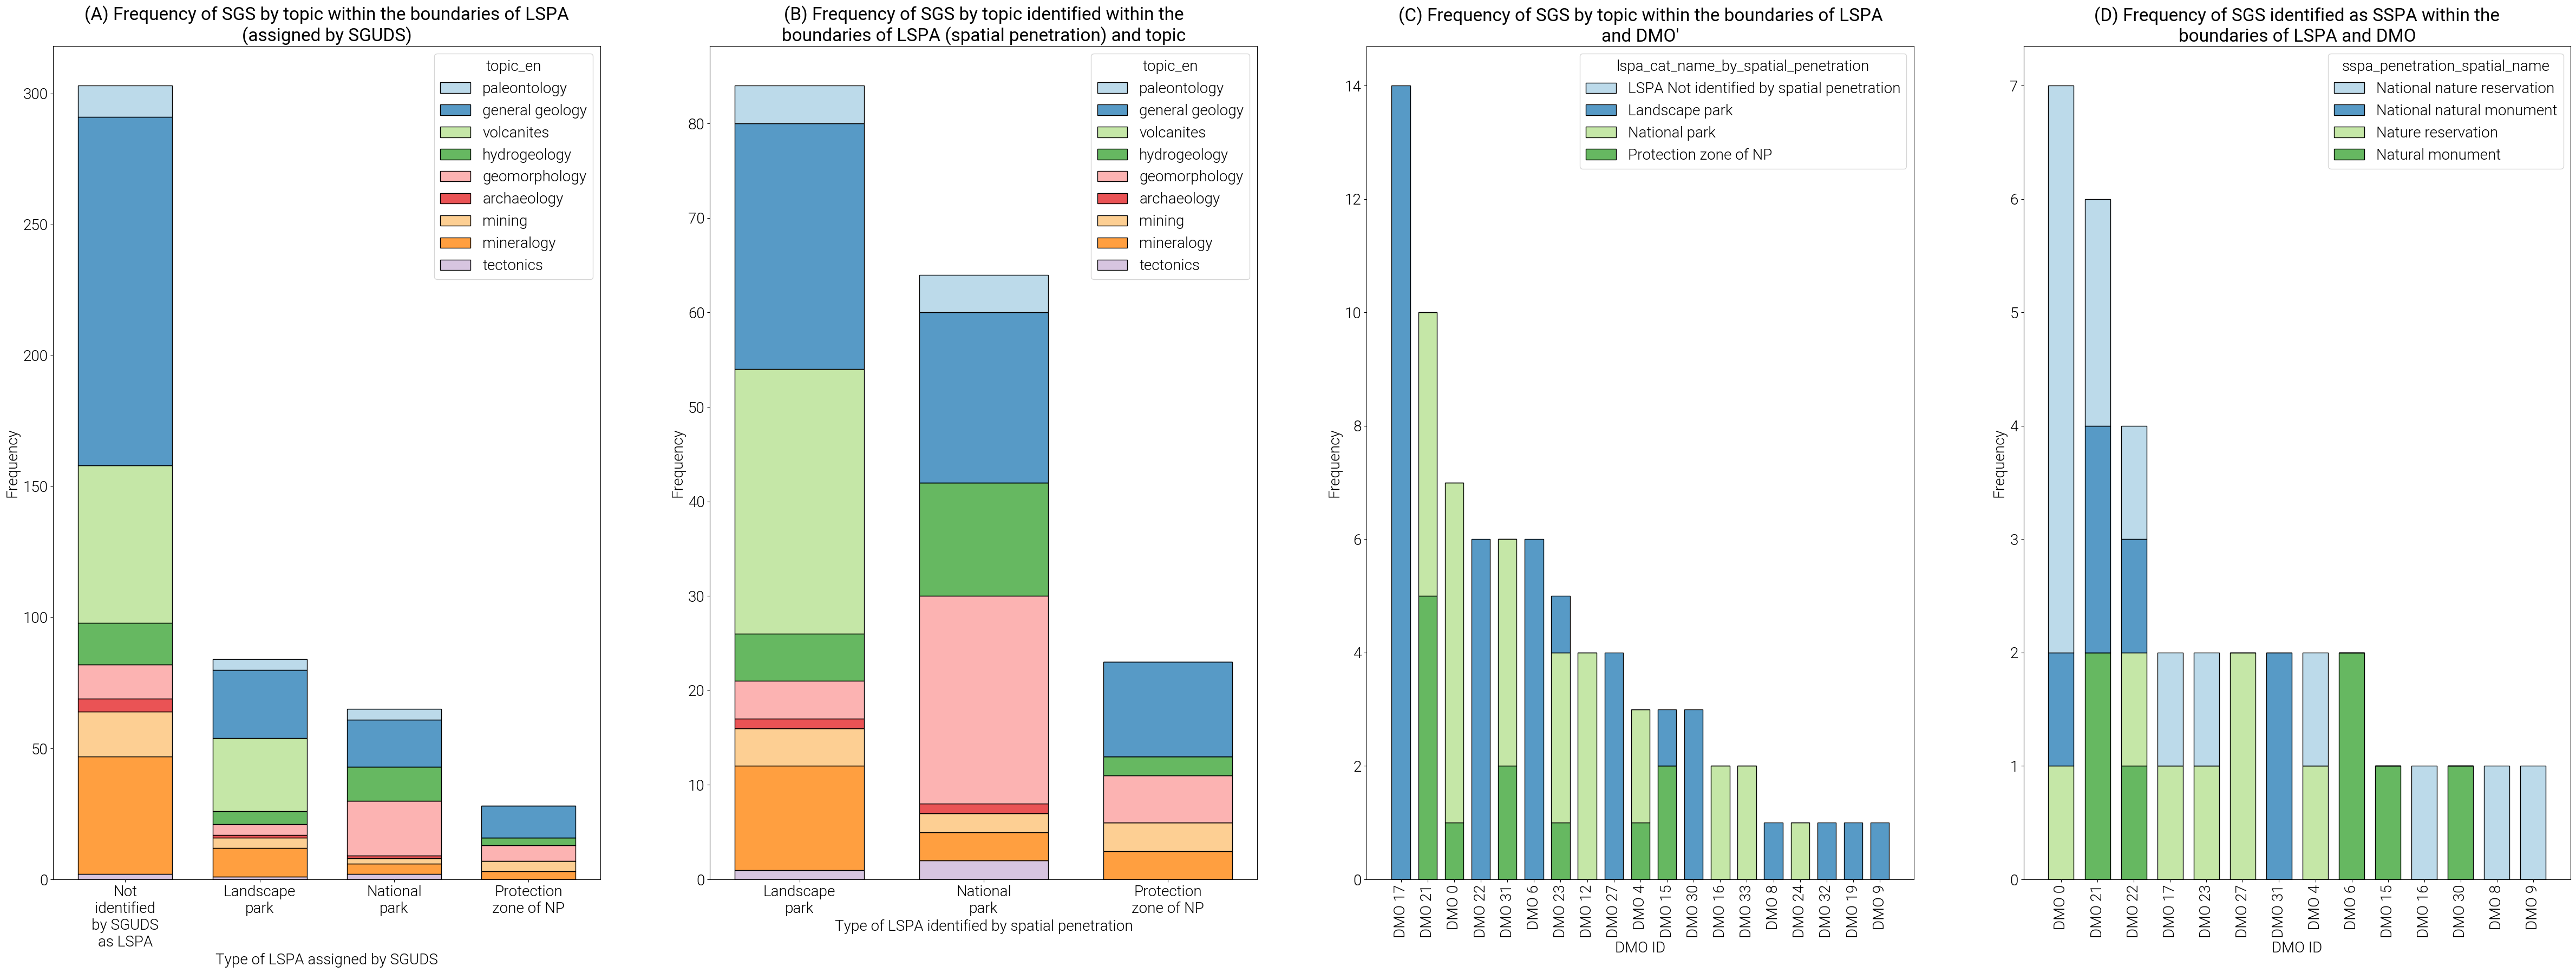

In [11]:
#LSPAs vs Topics
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(60, 20))
gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])


g1 = sns.histplot(data=df_sgs, x = "lspa_cat_sguds_en", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="topic_en" , ax=ax1)
#ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax1.set(xlabel="\n".join(textwrap.wrap('Type of LSPA assigned by SGUDS',60)), ylabel='Frequency')
ax1.set(title="\n".join(textwrap.wrap("(A) Frequency of SGS by topic within the boundaries of LSPA (assigned by SGUDS)",60)))
wrap_labels(ax1, 10)


g2 = sns.histplot(data=df_sgs.query('lspa_cat_name_by_spatial_penetration != "LSPA Not identified by spatial penetration"'), x = "lspa_cat_name_by_spatial_penetration", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="topic_en" , ax=ax2)
#ax2.set_xticklabels(g2.get_xticklabels(), rotation=90)
ax2.set(xlabel="\n".join(textwrap.wrap('Type of LSPA identified by spatial penetration',60)), ylabel='Frequency')
ax2.set_title("\n".join(textwrap.wrap("(B) Frequency of SGS by topic identified within the boundaries of LSPA (spatial penetration) and topic ", 60)))
wrap_labels(ax2, 10)

g3 = sns.histplot(data=df_grid1_g3, x = "nm_dmoid", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="lspa_cat_name_by_spatial_penetration" , ax=ax3)
ax3.set_xticklabels(g3.get_xticklabels(), rotation=90)
ax3.set(xlabel="\n".join(textwrap.wrap('DMO ID',60)), ylabel='Frequency')
ax3.set_title("\n".join(textwrap.wrap("(C) Frequency of SGS by topic within the boundaries of LSPA and DMO' ", 60)))
#wrap_labels(ax2, 10)

g4 = sns.histplot(data=df_grid1_g4, x = "nm_dmoid", stat="count",  multiple="stack", palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="sspa_penetration_spatial_name" , ax=ax4)
ax4.set_xticklabels(g4.get_xticklabels(), rotation=90)
ax4.set(xlabel="\n".join(textwrap.wrap('DMO ID',60)), ylabel='Frequency')
ax4.set_title("\n".join(textwrap.wrap("(D) Frequency of SGS identified as SSPA within the boundaries of LSPA and DMO", 60)))
#wrap_labels(ax2, 10)

plt.savefig("dumps/exported_figs/grid_lspa_sgs_freq.svg", bbox_inches="tight")


C:\Users\csb\AppData\Local\Temp\ipykernel_18892\4100836254.py:16: UserWarning: The palette list has more values (12) than needed (9), which may not be intended.
  g1 = sns.histplot(data=df_sgs, x = "sspa_cat_sguds_en", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\AppData\Local\Temp\ipykernel_18892\2612716474.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, rotation=0)
C:\Users\csb\AppData\Local\Temp\ipykernel_18892\4100836254.py:24: UserWarning: The palette list has more values (12) than needed (7), which may not be intended.
  g2 = sns.histplot(data=df_sgs.query('mchu_cat_nam

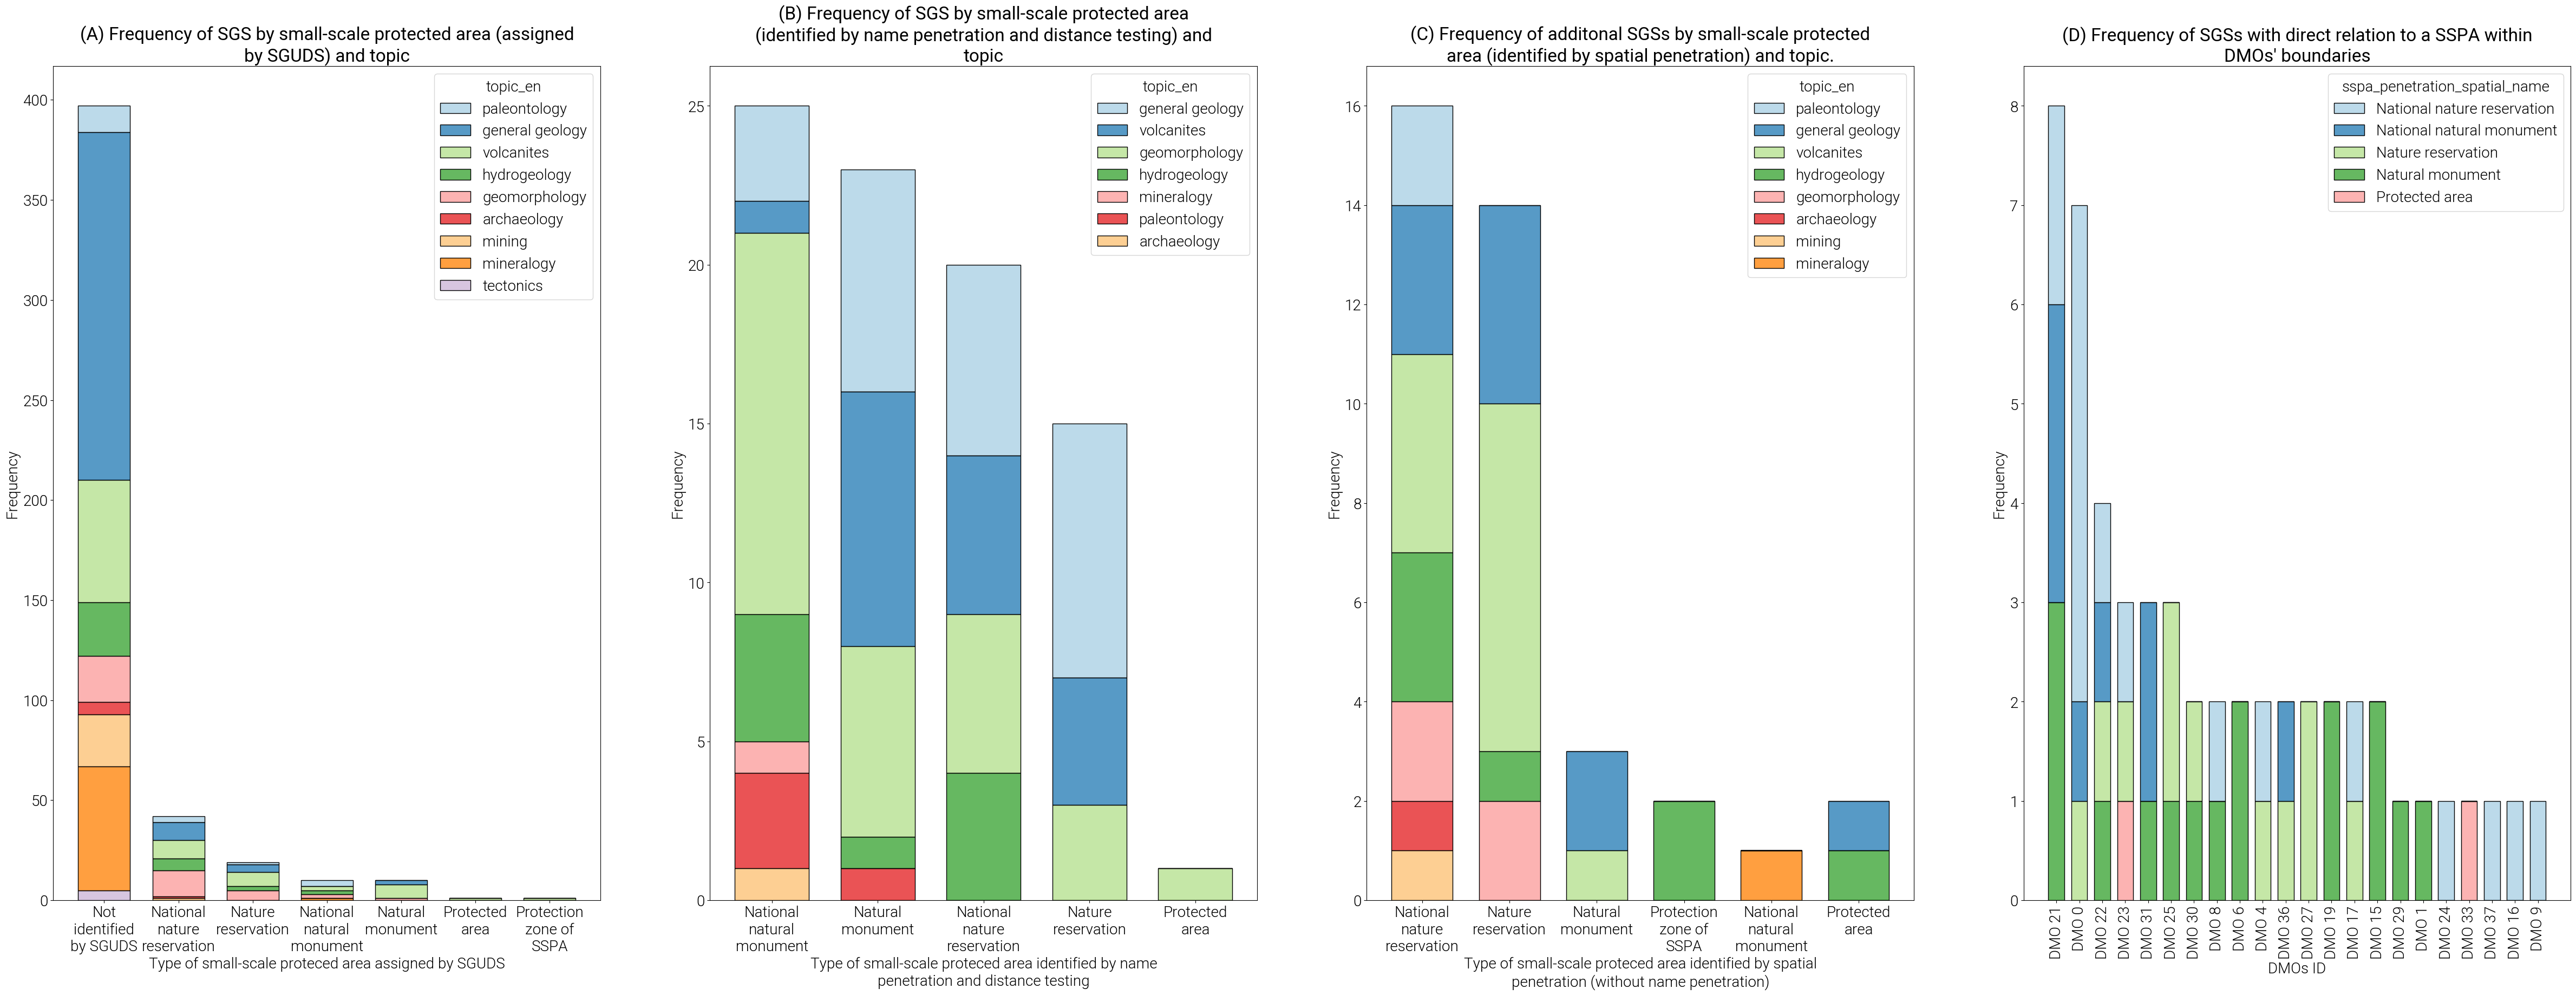

In [12]:
#SSPAs vs Topics
from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(60, 20))
gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])





g1 = sns.histplot(data=df_sgs, x = "sspa_cat_sguds_en", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="topic_en" , ax=ax1)
#ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax1.set(xlabel="\n".join(textwrap.wrap('Type of small-scale proteced area assigned by SGUDS',60)), ylabel='Frequency')
ax1.set(title="\n".join(textwrap.wrap("(A) Frequency of SGS by small-scale protected area (assigned by SGUDS) and topic ",60)))
wrap_labels(ax1, 10)


g2 = sns.histplot(data=df_sgs.query('mchu_cat_name_by_name_penetration_dist_test != "Not identified by name within 5 km"'), x = "mchu_cat_name_by_name_penetration_dist_test", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="topic_en" , ax=ax2)
#ax2.set_xticklabels(g2.get_xticklabels(), rotation=90)
ax2.set(xlabel="\n".join(textwrap.wrap('Type of small-scale proteced area identified by name penetration and distance testing',60)), ylabel='Frequency')
ax2.set_title("\n".join(textwrap.wrap("(B) Frequency of SGS by small-scale protected area (identified by name penetration and distance testing) and topic ", 60)))
wrap_labels(ax2, 10)



g3 = sns.histplot(data=df_sgs.query('mchu_cat_name_by_spatial_penetration != "Not identified by spatial penetration" and mchu_cat_name_by_name_penetration_dist_test == "Not identified by name within 5 km"'), x = "mchu_cat_name_by_spatial_penetration", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="topic_en" , ax=ax3)
ax3.set_xticklabels(g3.get_xticklabels(), rotation=90)
ax3.set(xlabel="\n".join(textwrap.wrap('Type of small-scale proteced area identified by spatial penetration (without name penetration)', 60)), ylabel='Frequency')
ax3.set_title("\n".join(textwrap.wrap("(C) Frequency of additonal SGSs by small-scale protected area (identified by spatial penetration) and topic.",60)))
wrap_labels(ax3, 10)

g4 = sns.histplot(data=df_sgs_sspa_dmo_sorted, 
                  x = "nm_dmoid", stat="count", multiple="stack",  palette = sns.color_palette("Paired") 
 ,kde=False,shrink = 0.7, hue="sspa_penetration_spatial_name" , ax=ax4)
ax4.set_xticklabels(g4.get_xticklabels(), rotation=90)
ax4.set(xlabel='DMOs ID', ylabel='Frequency')
ax4.set_title("\n".join(textwrap.wrap("(D) Frequency of SGSs with direct relation to a SSPA within DMOs' boundaries ",60)))


plt.savefig("dumps/exported_figs/grid_sspa_sgs_freq.svg", bbox_inches="tight")


C:\Users\csb\AppData\Local\Temp\ipykernel_2216\3455971291.py:41: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  g1 = sns.histplot(data=df_sgs_sorted_tema, x = "topic_en", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\AppData\Local\Temp\ipykernel_2216\3455971291.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

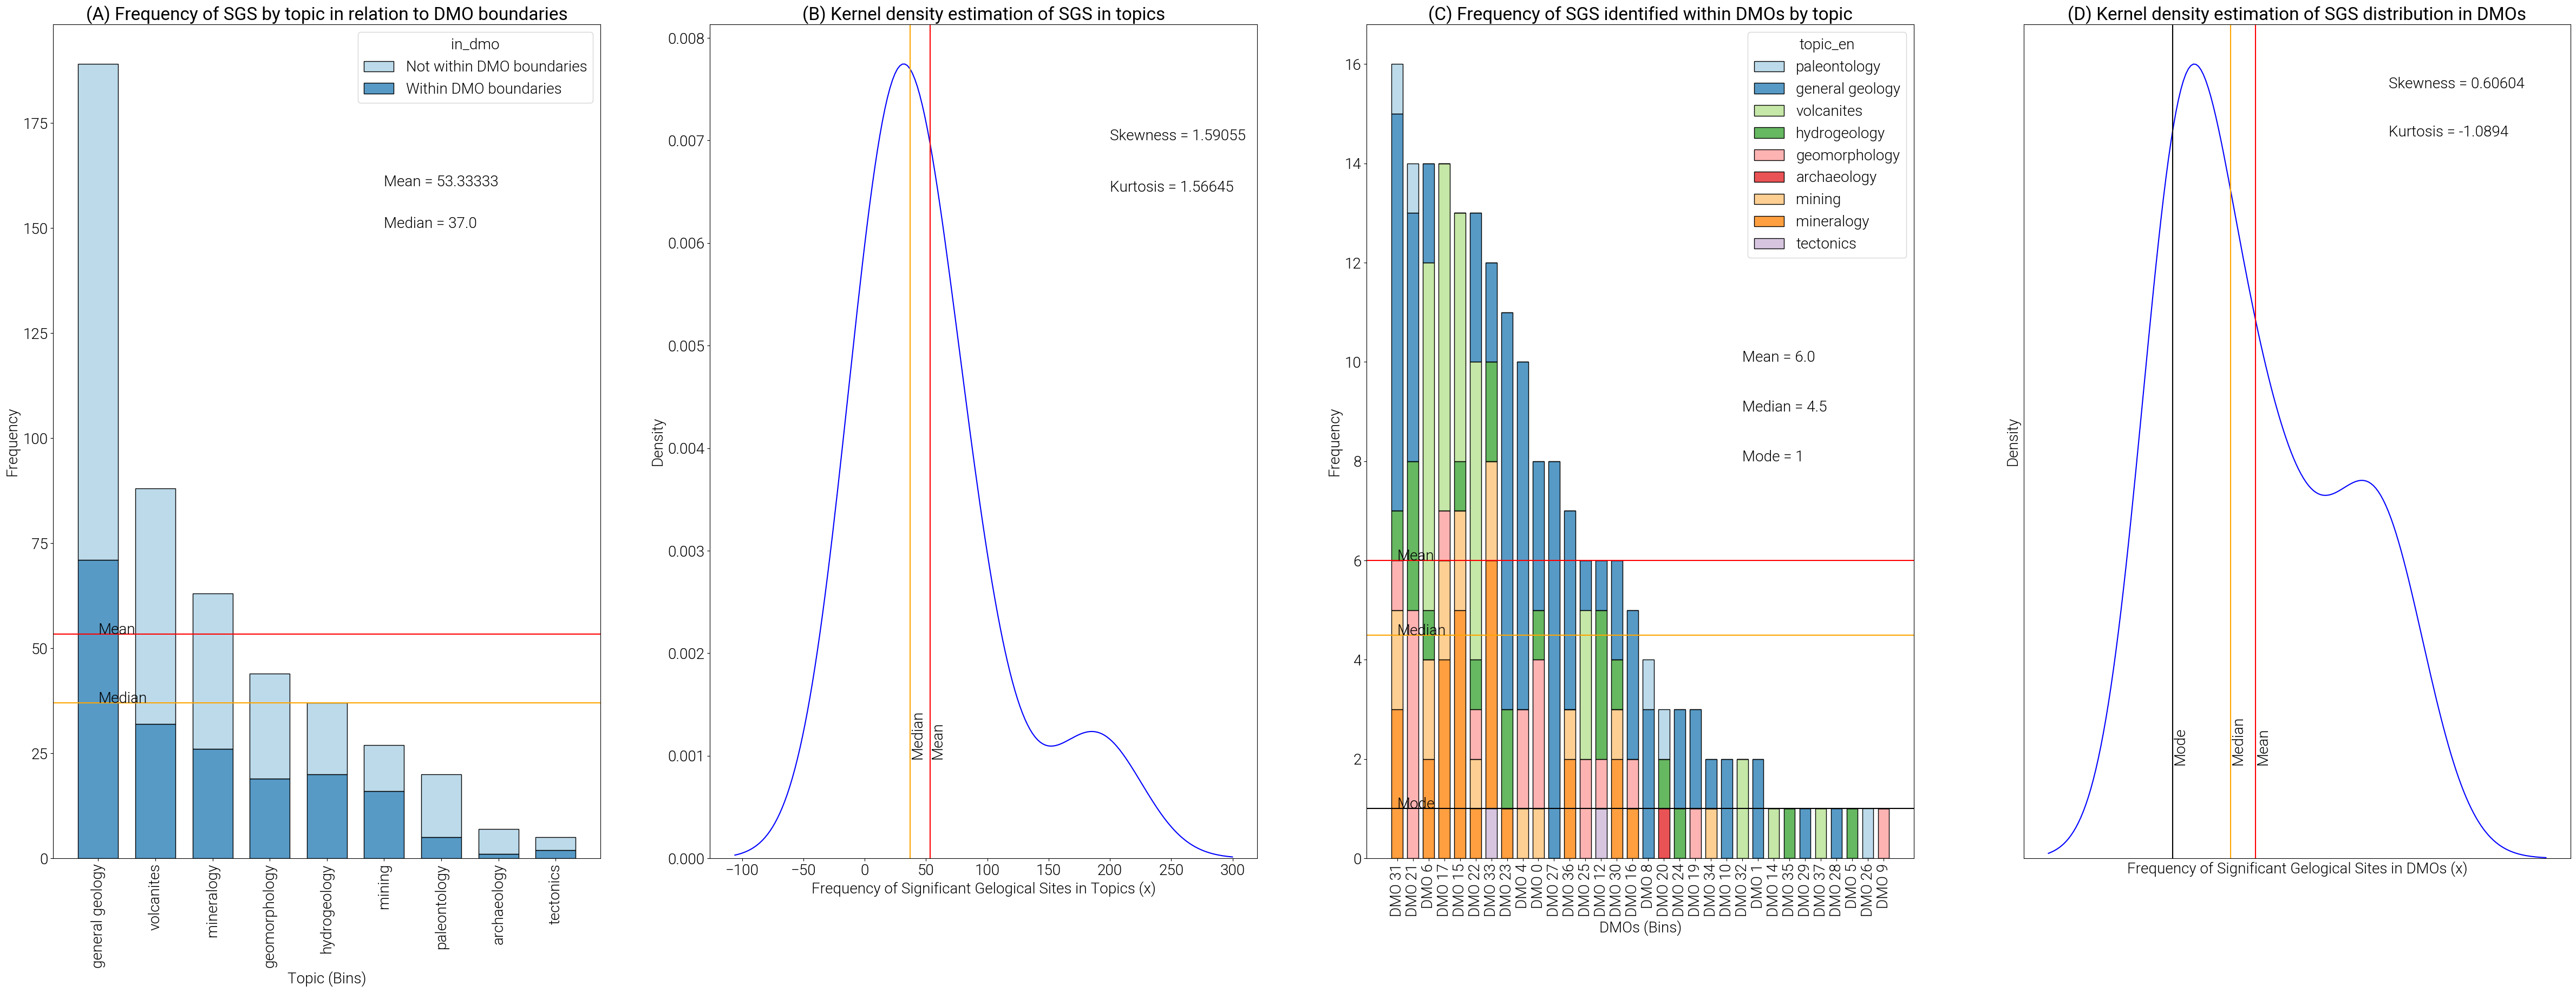

In [89]:
#GRID TOPICS AND DMOS
from scipy.stats import skew, kurtosis


df_group_tema = df_sgs.groupby("topic_en", dropna=False).count()

df_sgs_sorted_tema = df_sgs.copy() 
df_sgs_sorted_tema['topic_en'] = pd.Categorical(df_sgs_sorted['topic_en'], list(df_group_tema.sort_values(by=['objectid'], ascending=False).index))

#SGS TOPICS
#Find base descritives of position a shape
mean_x_g1 = df_group_tema.objectid.mean()
median_x_g1 = df_group_tema.objectid.median()
mode_x_g1 = df_group_tema.objectid.mode()
skew_x_g1 = skew(df_group_tema.objectid)
kurt_x_g1 = kurtosis(df_group_tema.objectid)

#print("Mean x_g1", mean_x_g1)
#print("Median x_g1", median_x_g1)
#print("Mode x_g1", mode_x_g1)
#print("Skew x_g1", skew_x_g1)
#print("Kurtosis x_g1", kurt_x_g1)

#SGS DMOs
mean_x_g3 = df_group_dmo.objectid.mean()
median_x_g3 = df_group_dmo.objectid.median()
mode_x_g3 = df_group_dmo.objectid.mode().squeeze()
skew_x_g3 = skew(df_group_dmo.objectid)
kurt_x_g3 = kurtosis(df_group_dmo.objectid)

#THE GRID
from matplotlib.gridspec import GridSpec
fig = plt.figure(figsize=(60, 20))
gs = GridSpec(1, 4, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[0, 3])

g1 = sns.histplot(data=df_sgs_sorted_tema, x = "topic_en", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="in_dmo" , ax=ax1)
ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax1.set(xlabel='Topic (Bins)', ylabel='Frequency')
ax1.set(title="(A) Frequency of SGS by topic in relation to DMO boundaries")
ax1.axhline(mean_x_g1, color=clr_mean, label="Mean")
ax1.axhline(median_x_g1, color=clr_median, label="Median")
ax1.annotate("Mean", xy=(0,mean_x_g1))
ax1.annotate("Median", xy=(0,median_x_g1))
ax1.annotate("Mean = " + str(round(mean_x_g1,5)), xy=(5,160))
ax1.annotate("Median = " + str(round(median_x_g1,5)), xy=(5,150))


g2 =sns.kdeplot(df_group_tema.objectid, color="blue", ax=ax2)
#ax2.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax2.set(xlabel='Frequency of Significant Gelogical Sites in Topics (x)', ylabel='Density')
ax2.set(title="(B) Kernel density estimation of SGS in topics")
ax2.axvline(mean_x_g1, color=clr_mean, label="Mean")
ax2.axvline(median_x_g1, color=clr_median, label="Median")
ax2.annotate("Mean", xy=(mean_x_g1,0.001),rotation=90)
ax2.annotate("Median", xy=(median_x_g1,0.001),rotation=90)
ax2.annotate("Skewness = " + str(round(skew_x_g1,5)), xy=(200,0.007))
ax2.annotate("Kurtosis = " + str(round(kurt_x_g1,5)), xy=(200,0.0065))


g3 = sns.histplot(data=df_sgs_sorted, x = "nm_dmoid", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="topic_en" , ax=ax3)
ax3.set_xticklabels(g3.get_xticklabels(), rotation=90)
ax3.axhline(mean_x_g3, color=clr_mean, label="Mean")
ax3.axhline(median_x_g3, color=clr_median, label="Median")
ax3.axhline(mode_x_g3, color=clr_mode, label="Mode")
ax3.annotate("Mean", xy=(0,mean_x_g3))
ax3.annotate("Median", xy=(0,median_x_g3))
ax3.annotate("Mode", xy=(0,mode_x_g3))
ax3.annotate("Mean = " + str(mean_x_g3), xy=(22,10))
ax3.annotate("Median = " + str(median_x_g3), xy=(22,9))
ax3.annotate("Mode = " + str(mode_x_g3), xy=(22,8))
ax3.set(xlabel='DMOs (Bins)', ylabel='Frequency')
ax3.set(title="(C) Frequency of SGS identified within DMOs by topic")


g4 =sns.kdeplot(df_group_dmo.objectid, color="blue", ax=ax4)
ax4.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax4.set(xlabel='Frequency of Significant Gelogical Sites in DMOs (x)', ylabel='Density')
ax4.set(title="(D) Kernel density estimation of SGS distribution in DMOs")
ax4.axvline(mean_x_g3, color=clr_mean, label="Mean")
ax4.axvline(median_x_g3, color=clr_median, label="Median")
ax4.axvline(mode_x_g3, color=clr_mode, label="Mode")
ax4.annotate("Mean", xy=(mean_x_g3,0.01),rotation=90)
ax4.annotate("Median", xy=(median_x_g3,0.01),rotation=90)
ax4.annotate("Mode", xy=(mode_x_g3,0.01),rotation=90)
ax4.annotate("Skewness = " + str(round(skew_x_g3,5)), xy=(14,0.08))
ax4.annotate("Kurtosis = " + str(round(kurt_x_g3,5)), xy=(14,0.075))


plt.savefig("dumps/exported_figs/grid_dmos_topics_freq.svg", bbox_inches="tight")


Mean 6.0
Median 4.5
Mode 1
Skew 0.6060368929996077
Kurtosis -1.0893983731106875


C:\Users\csb\AppData\Local\Temp\ipykernel_3392\2237447213.py:30: UserWarning: The palette list has more values (12) than needed (9), which may not be intended.
  g1 = sns.histplot(data=df_sgs_sorted, x = "nm_dmoid", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\AppData\Local\Temp\ipykernel_3392\2237447213.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating 

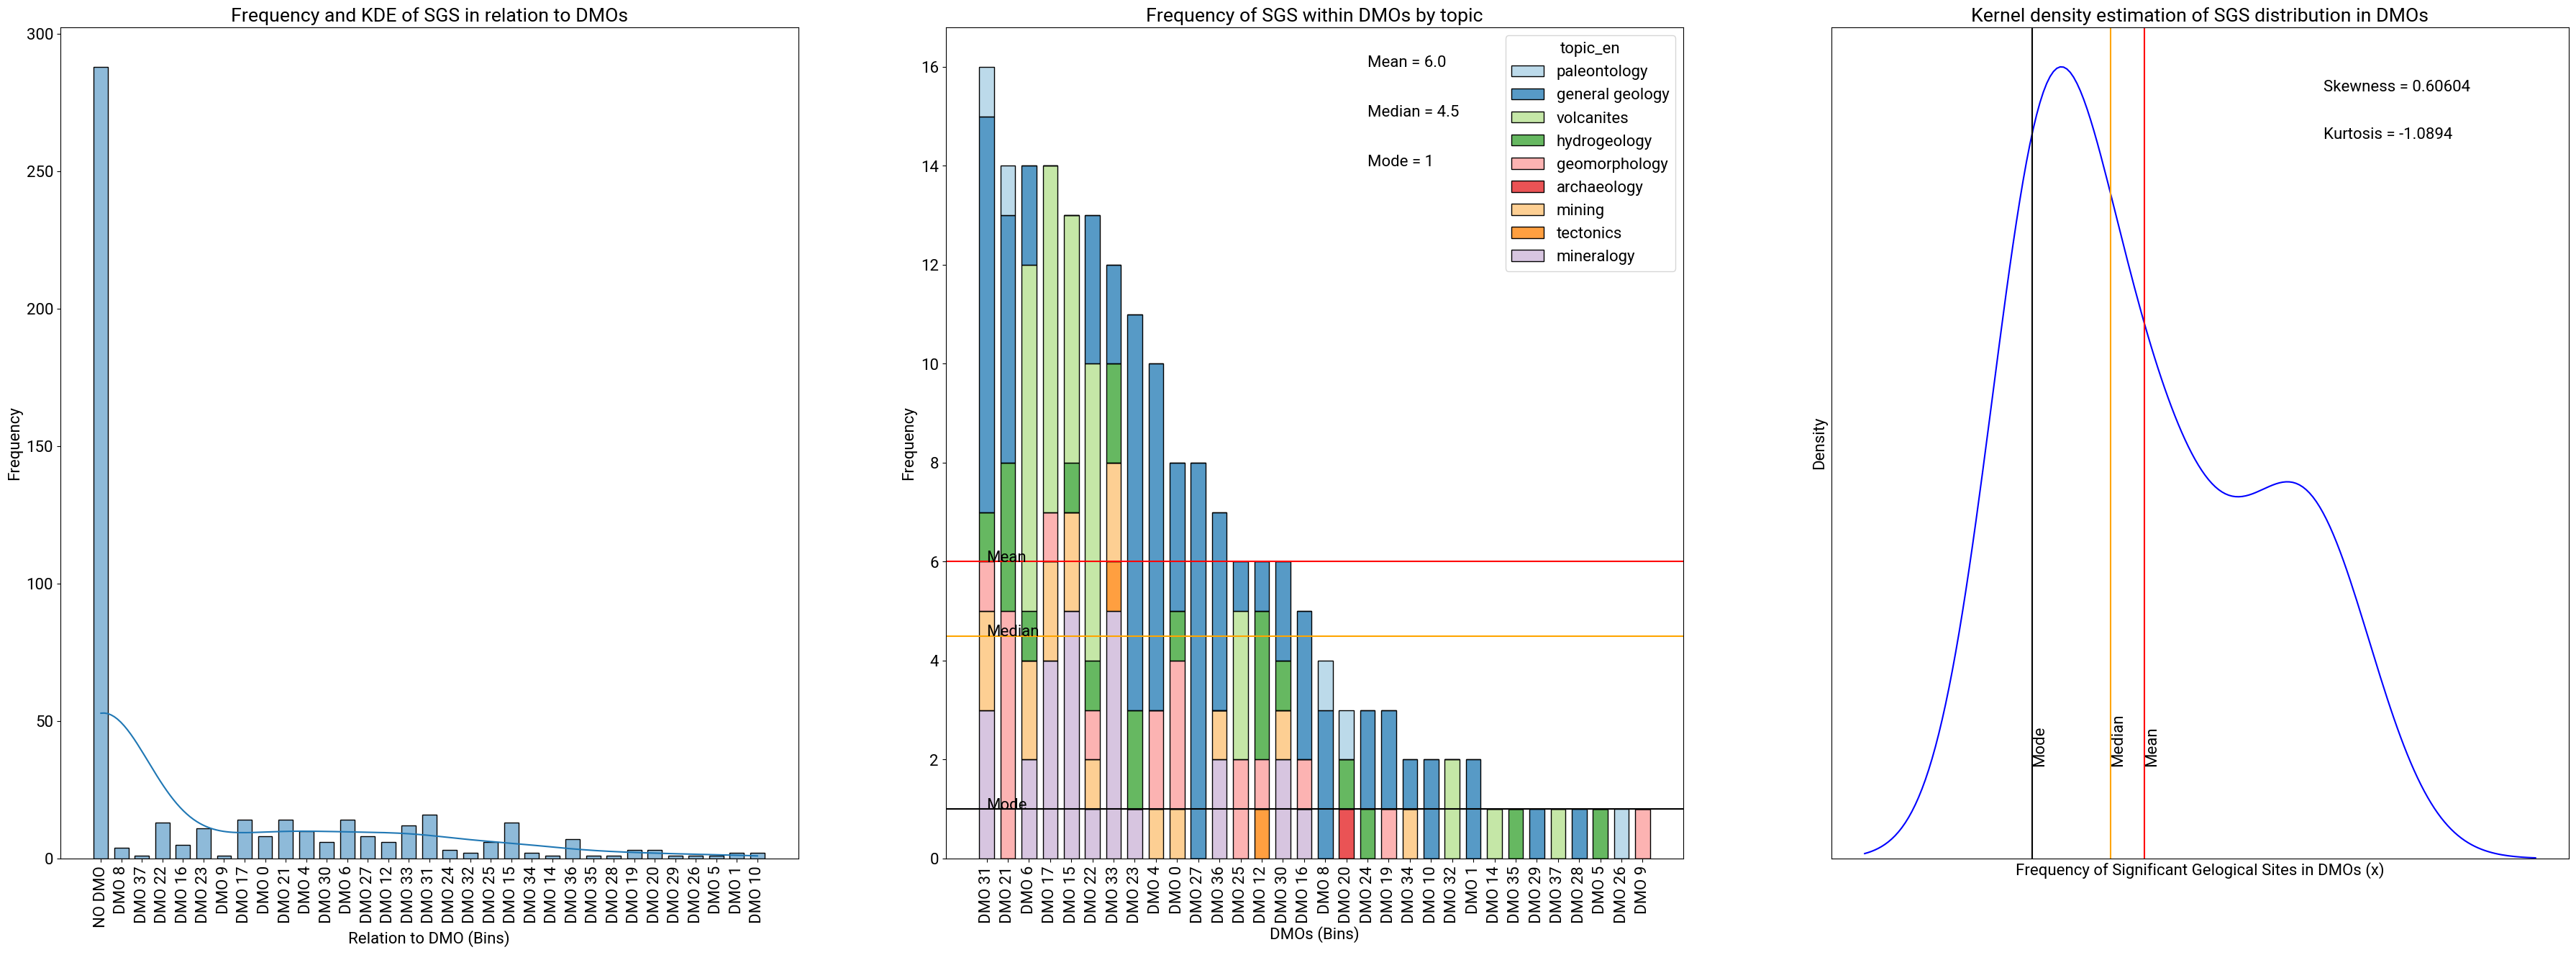

In [65]:
#DMOS
# Find the mean, median, mode
mean_x = df_group_dmo.objectid.mean()
median_x = df_group_dmo.objectid.median()
mode_x = df_group_dmo.objectid.mode().squeeze()
from scipy.stats import skew, kurtosis
skew_x = skew(df_group_dmo.objectid)
kurt_x = kurtosis(df_group_dmo.objectid)


print("Mean", mean_x)
print("Median", median_x)
print("Mode", mode_x)
print("Skew", skew_x)
print("Kurtosis", kurt_x)

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(45, 15))
gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 0])
#ax4 = fig.add_subplot(gs[1,0])




g1 = sns.histplot(data=df_sgs_sorted, x = "nm_dmoid", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="topic_en" , ax=ax1)
ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax1.axhline(mean_x, color=clr_mean, label="Mean")
ax1.axhline(median_x, color=clr_median, label="Median")
ax1.axhline(mode_x, color=clr_mode, label="Mode")
ax1.annotate("Mean", xy=(0,mean_x))
ax1.annotate("Median", xy=(0,median_x))
ax1.annotate("Mode", xy=(0,mode_x))
ax1.annotate("Mean = " + str(mean_x), xy=(18,16))
ax1.annotate("Median = " + str(median_x), xy=(18,15))
ax1.annotate("Mode = " + str(mode_x), xy=(18,14))
ax1.set(xlabel='DMOs (Bins)', ylabel='Frequency')
ax1.set(title="Frequency of SGS within DMOs by topic")


g2 =sns.kdeplot(df_group_dmo.objectid, color="blue", ax=ax2)
ax2.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax2.set(xlabel='Frequency of Significant Gelogical Sites in DMOs (x)', ylabel='Density')
ax2.set(title="Kernel density estimation of SGS distribution in DMOs")
ax2.axvline(mean_x, color=clr_mean, label="Mean")
ax2.axvline(median_x, color=clr_median, label="Median")
ax2.axvline(mode_x, color=clr_mode, label="Mode")
ax2.annotate("Mean", xy=(mean_x,0.01),rotation=90)
ax2.annotate("Median", xy=(median_x,0.01),rotation=90)
ax2.annotate("Mode", xy=(mode_x,0.01),rotation=90)
ax2.annotate("Skewness = " + str(round(skew_x,5)), xy=(14,0.08))
ax2.annotate("Kurtosis = " + str(round(kurt_x,5)), xy=(14,0.075))



g3 = sns.histplot(data=df_sgs, x = "nm_dmoid", bins=5, kde=True, shrink =0.7, ax=ax3)
ax3.set_xticklabels(g3.get_xticklabels(), rotation=90)
ax3.set(xlabel='Relation to DMO (Bins)', ylabel='Frequency')
ax3.set(title="Frequency and KDE of SGS in relation to DMOs")


#g4 = sns.histplot(data=df_sgs_sorted_tema, x = "tema", kde=False,shrink = 0.5, ax=ax4)
#ax4.set_xticklabels(g4.get_xticklabels(), rotation=90)


# Add vertical lines at the position of mean, median, mode

#plt.axvline(mode_price, color="green", label="Mode")


plt.savefig("dumps/exported_figs/grid_dmos_freq.svg")
#https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis

Mean 53.333333333333336
Median 37.0
Mode 0      5
1      7
2     20
3     27
4     37
5     44
6     63
7     88
8    189
Name: objectid, dtype: int64
Skew 1.5905470630790721
Kurtosis 1.5664482431818598


C:\Users\csb\AppData\Local\Temp\ipykernel_16168\589946093.py:37: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  g1 = sns.histplot(data=df_sgs_sorted_tema, x = "topic_en", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\csb\AppData\Local\Temp\ipykernel_16168\589946093.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
C:\Users\csb\AppData\Local\Temp\ipykernel_16168\589946093.py:54: UserWarning: 
The palette list has fewer values (12) than needed (32) and will cycle, which may produce an uninterpretable plot.
 

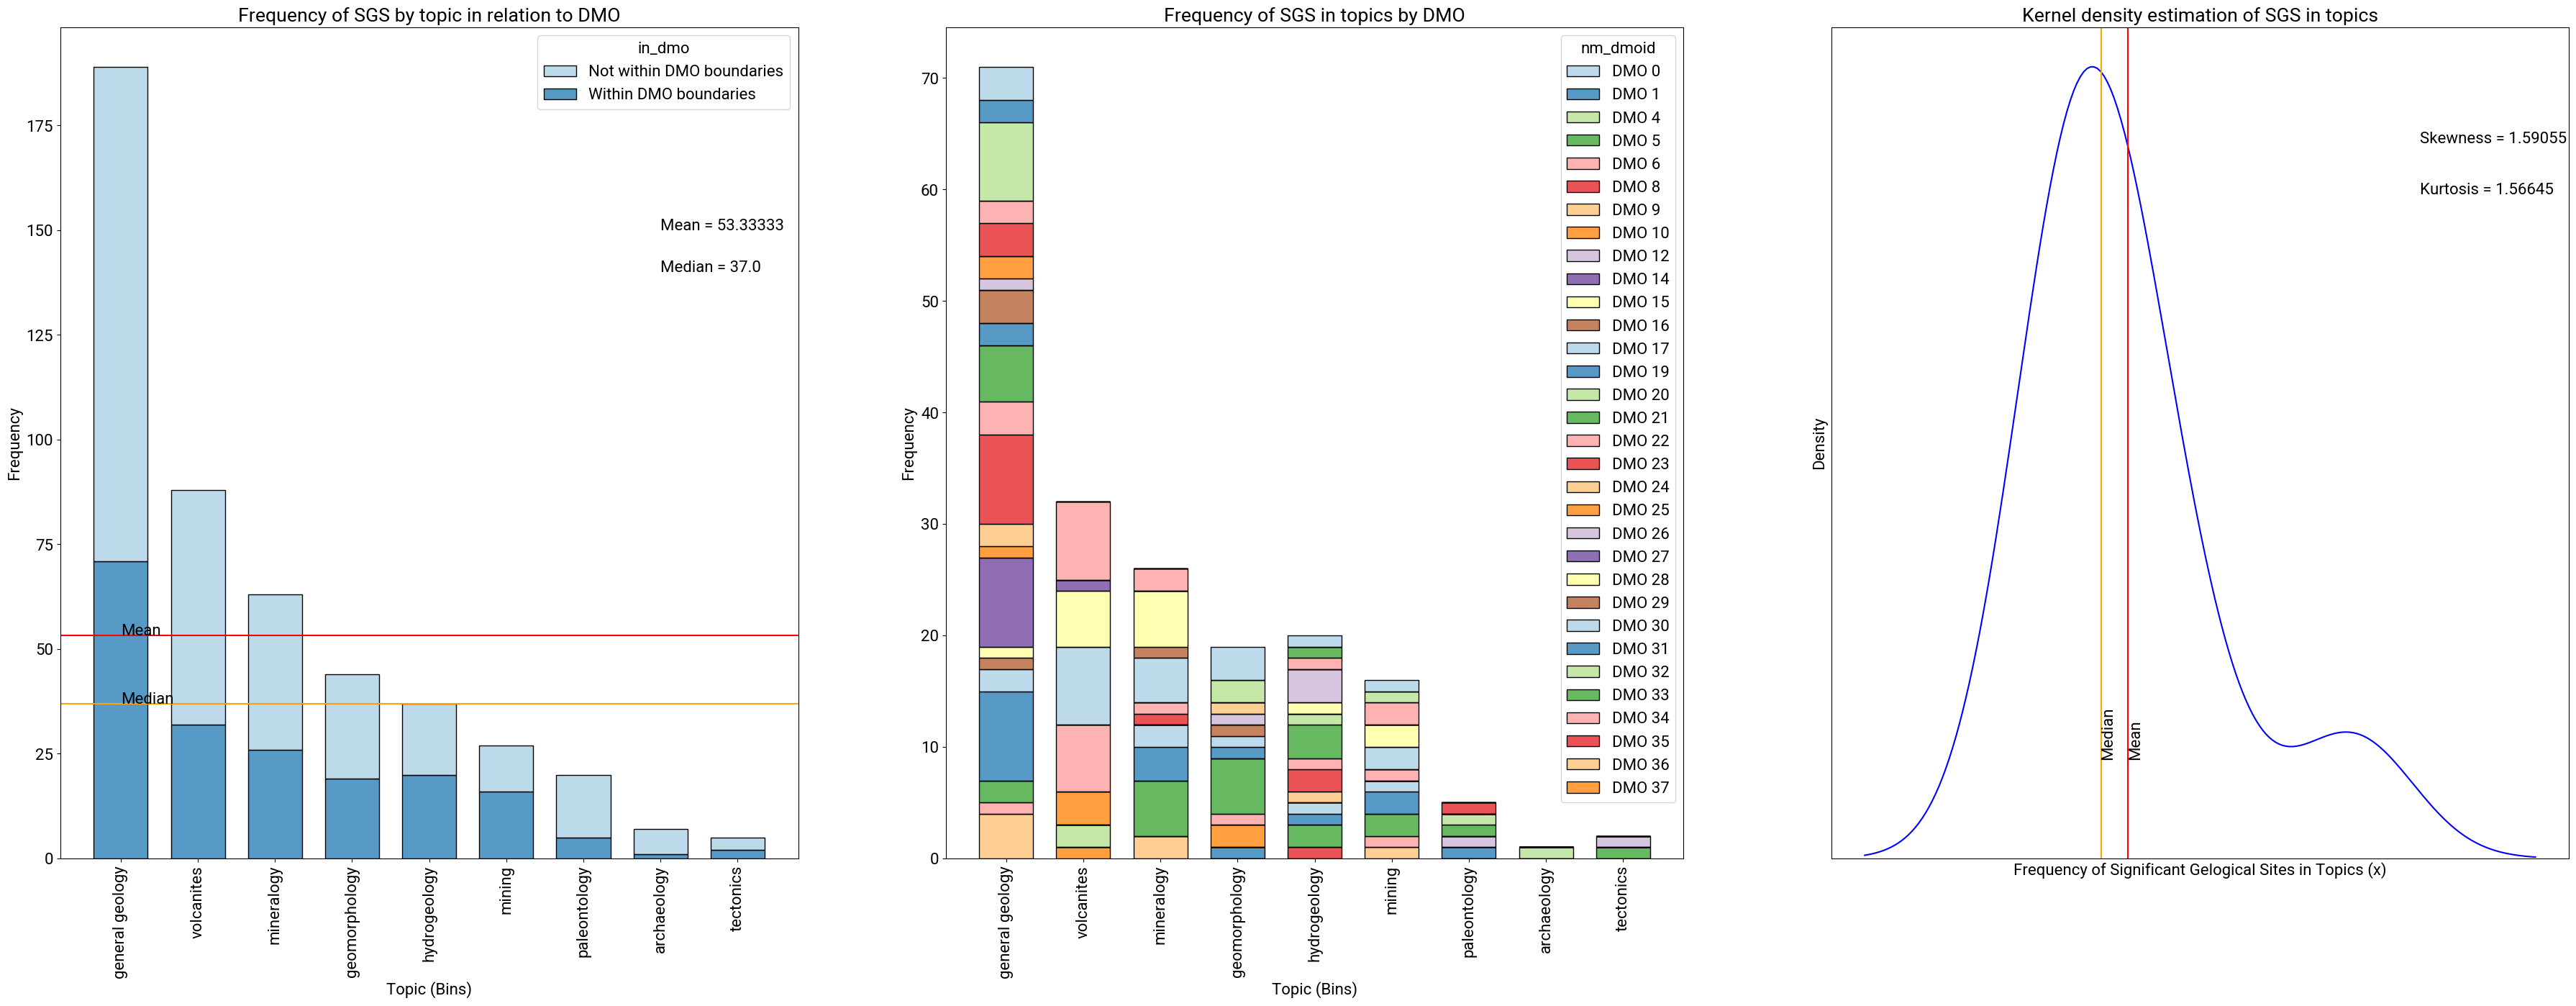

In [96]:



print("Mean", mean_x)
print("Median", median_x)
print("Mode", mode_x)
print("Skew", skew_x)
print("Kurtosis", kurt_x)

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(45, 15))
gs = GridSpec(1, 3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
#ax4 = fig.add_subplot(gs[1,0])

g1 = sns.histplot(data=df_sgs_sorted_tema, x = "topic_en", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="in_dmo" , ax=ax1)
ax1.set_xticklabels(g1.get_xticklabels(), rotation=90)
ax1.set(xlabel='Topic (Bins)', ylabel='Frequency')
ax1.set(title="Frequency of SGS by topic in relation to DMO")
ax1.axhline(mean_x, color=clr_mean, label="Mean")
ax1.axhline(median_x, color=clr_median, label="Median")
#ax1.axhline(mode_x, color=clr_mode, label="Mode")
ax1.annotate("Mean", xy=(0,mean_x))
ax1.annotate("Median", xy=(0,median_x))
#ax1.annotate("Mode", xy=(0,mode_x))
ax1.annotate("Mean = " + str(round(mean_x,5)), xy=(7,150))
ax1.annotate("Median = " + str(round(median_x,5)), xy=(7,140))
#ax1.annotate("Mode = " + str(mode_x), xy=(7,149))

g2_legend_order =  df_sgs_sorted_tema.query('in_dmo == "Within DMO boundaries"')[['dmo_id', 'nm_dmoid']].sort_values(by=['dmo_id'])['nm_dmoid'].unique()

g2 = sns.histplot(data=df_sgs_sorted_tema.query('in_dmo == "Within DMO boundaries"'), x = "topic_en", stat="count", multiple="stack",  palette = sns.color_palette("Paired")
 ,kde=False,shrink = 0.7, hue="nm_dmoid" , hue_order = g2_legend_order, ax=ax2)
ax2.set_xticklabels(g2.get_xticklabels(), rotation=90)
ax2.set(xlabel='Topic (Bins)', ylabel='Frequency')
ax2.set(title="Frequency of SGS in topics by DMO")




g2 =sns.kdeplot(df_group_tema.objectid, color="blue", ax=ax3)
ax3.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
ax3.set(xlabel='Frequency of Significant Gelogical Sites in Topics (x)', ylabel='Density')
ax3.set(title="Kernel density estimation of SGS in topics")
ax3.axvline(mean_x, color=clr_mean, label="Mean")
ax3.axvline(median_x, color=clr_median, label="Median")
#ax3.axvline(mode_x, color=clr_mode, label="Mode")
ax3.annotate("Mean", xy=(mean_x,0.001),rotation=90)
ax3.annotate("Median", xy=(median_x,0.001),rotation=90)
#ax3.annotate("Mode", xy=(mode_x,0.01),rotation=90)
ax3.annotate("Skewness = " + str(round(skew_x,5)), xy=(230,0.007))
ax3.annotate("Kurtosis = " + str(round(kurt_x,5)), xy=(230,0.0065))





#g4 = sns.histplot(data=df_sgs_sorted_tema, x = "tema", kde=False,shrink = 0.5, ax=ax4)
#ax4.set_xticklabels(g4.get_xticklabels(), rotation=90)


# Add vertical lines at the position of mean, median, mode

#plt.axvline(mode_price, color="green", label="Mode")


plt.savefig("dumps/exported_figs/grid_topic_sgs.svg")
#https://www.datacamp.com/tutorial/understanding-skewness-and-kurtosis

In [98]:
type(g2_legend_order)

numpy.ndarray

C:\Users\csb\anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Count')

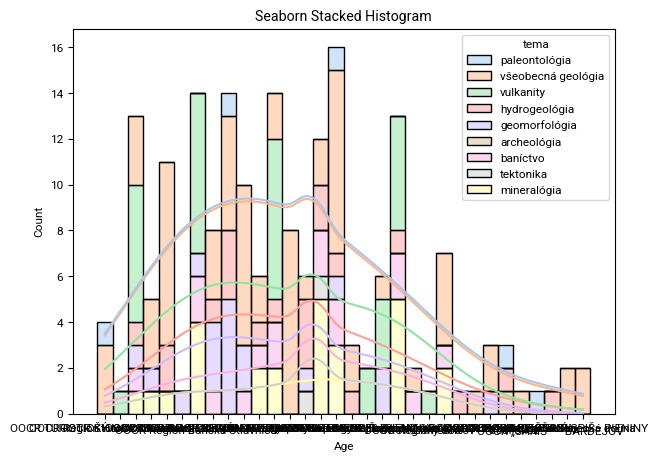

In [21]:
df_sample = df_sgs[["dmo_name", "tema", "objectid"]]
# stacked histogram
import matplotlib.pyplot as plt
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

# mock your data frame
import pandas as pd
import numpy as np

# plot
import seaborn as sns
sns.histplot(data=df_sample, ax=ax, stat="count", multiple="stack",
             x="dmo_name", kde=True,
             palette="pastel", hue="tema",
             element="bars", legend=True)
ax.set_title("Seaborn Stacked Histogram")
ax.set_xlabel("Age")
ax.set_ylabel("Count")

In [17]:
df_sample = df_sgs[["dmo_name", "tema", "objectid"]]
df_sample

,dmo_name,tema,objectid
0,None,paleontológia,399
1,None,všeobecná geológia,380
2,OOCR Región Horné Považie,všeobecná geológia,289
3,None,vulkanity,176
4,None,všeobecná geológia,432
...,...,...,...
475,None,vulkanity,394
476,None,baníctvo,357
477,OOCR REZORT PIEŠŤANY,archeológia,260
478,None,archeológia,187


In [5]:
iris = sns.load_dataset("iris")
species = iris.pop("species")
#sns.clustermap(iris)


print(species)
"""
df_group_tema['tpc'] = df_group_tema.index

dfxx = df_group_tema[['tpc', 'siteid_cat10_sk_vchu_lps_sopsr', 'in_dmo']]
dfxx.reset_index(drop=True, inplace=True)
dfxx_pop = dfxx.pop("tpc")
sns.clustermap(dfxx)


#species = iris.pop("species")
#sns.clustermap(dmos)
#df_group_tema
#df_group_tema
#species
#species
dfxx
"""

0         setosa
1         setosa
2         setosa
3         setosa
4         setosa
         ...    
145    virginica
146    virginica
147    virginica
148    virginica
149    virginica
Name: species, Length: 150, dtype: object


'\ndf_group_tema[\'tpc\'] = df_group_tema.index\n\ndfxx = df_group_tema[[\'tpc\', \'siteid_cat10_sk_vchu_lps_sopsr\', \'in_dmo\']]\ndfxx.reset_index(drop=True, inplace=True)\ndfxx_pop = dfxx.pop("tpc")\nsns.clustermap(dfxx)\n\n\n#species = iris.pop("species")\n#sns.clustermap(dmos)\n#df_group_tema\n#df_group_tema\n#species\n#species\ndfxx\n'

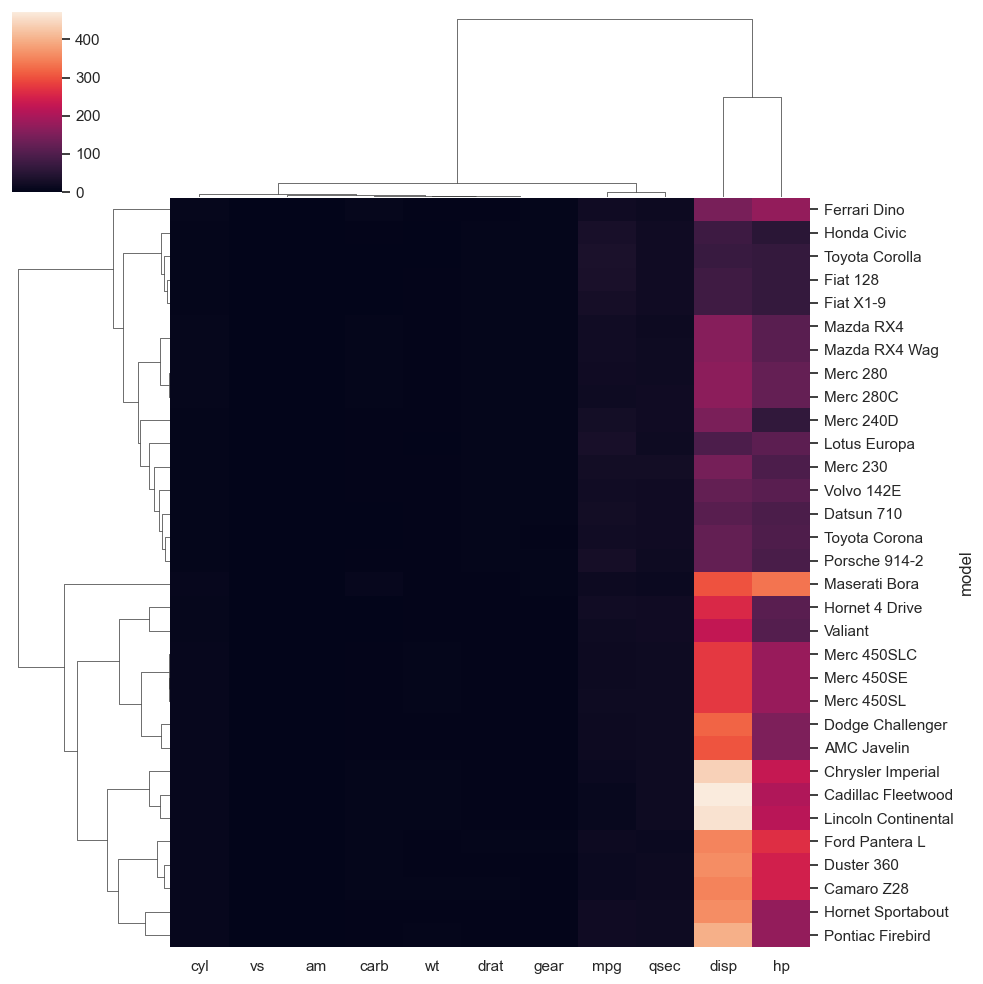

In [20]:
# Libraries
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt
 
# Data set
url = 'https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/mtcars.csv'
df = pd.read_csv(url)
df = df.set_index('model')
 
# Default plot
sns.clustermap(df)

# Show the graph
plt.show()

In [17]:
df

,model,mpg,cyl,disp,hp,drat,wt,qsec,vs,am,gear,carb
0,Mazda RX4,21.0,6,160.0,110,3.90,2.620,16.46,0,1,4,4
1,Mazda RX4 Wag,21.0,6,160.0,110,3.90,2.875,17.02,0,1,4,4
2,Datsun 710,22.8,4,108.0,93,3.85,2.320,18.61,1,1,4,1
3,Hornet 4 Drive,21.4,6,258.0,110,3.08,3.215,19.44,1,0,3,1
4,Hornet Sportabout,18.7,8,360.0,175,3.15,3.440,17.02,0,0,3,2
5,Valiant,18.1,6,225.0,105,2.76,3.460,20.22,1,0,3,1
6,Duster 360,14.3,8,360.0,245,3.21,3.570,15.84,0,0,3,4
7,Merc 240D,24.4,4,146.7,62,3.69,3.190,20.00,1,0,4,2
8,Merc 230,22.8,4,140.8,95,3.92,3.150,22.90,1,0,4,2
9,Merc 280,19.2,6,167.6,123,3.92,3.440,18.30,1,0,4,4


In [11]:
# Importing the library 
import seaborn as sns 
#from sunbird.categorical_encoding import frequency_encoding 
  
# Load dataset 
data = sns.load_dataset('flights') 
  
# Categorical encoding 
#frequency_encoding(data, 'month') 
  
# Clustering data row-wise and 
# changing color of the map. 
#sns.clustermap(data, cmap='coolwarm', figsize=(7, 7)) 
data

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121
...,...,...,...
139,1960,Aug,606
140,1960,Sep,508
141,1960,Oct,461
142,1960,Nov,390


In [7]:
df

network           1                     5                     6             \
node              1                     1                     1              
hemi             lh         rh         lh         rh         lh         rh   
0         56.055744  92.031036 -35.898861  -1.889181   5.898688 -43.692322   
1         55.547253  43.690075  19.568010  15.902983 -23.231823 -10.745867   
2         60.997768  63.438793  19.247454  37.209419   2.392153  16.509109   
3         18.514868  12.657158  32.896915  11.199619 -14.665752   2.073715   
4         -2.527392 -63.104668  18.396759   3.219077 -41.856911 -24.690414   
..              ...        ...        ...        ...        ...        ...   
915       -7.429513  -4.813219   0.017912 -25.305094 -75.461159 -70.289261   
916      -33.554138 -38.605621 -32.935612 -21.783203 -16.198238 -34.893780   
917      -78.539566 -74.197189 -32.800556 -37.021500   2.098941 -18.581594   
918     -103.235825 -98.744286 -14.330512 -17.224781  -3.007454 -42.672840   
919      -36.288868 -10.762070  26.558777  21.377319   9.652065  12.693388   

network                                7             ...         13  \
node             2                     1             ...          2   
hemi            lh         rh         lh         rh  ...         rh   
0       -47.664265  12.284122   1.566538 -13.042585  ...  14.738475   
1        10.269546  31.275831 -26.309488 -18.077026  ...  23.792282   
2        -5.314236   2.372976  -7.342168 -24.550989  ...   8.968520   
3        32.634335  45.825409 -47.632999  -6.580215  ...  19.627728   
4       -33.975418 -24.149668  -6.315651 -29.344135  ...  55.853088   
..             ...        ...        ...        ...  ...        ...   
915     -13.119029  -5.194376 -56.022263 -24.290606  ... -19.436220   
916      16.504656  13.005379  26.230785   4.764211  ...  16.711153   
917      11.386637   3.676295  52.871113  -3.970096  ...  45.261150   
918       1.581095 -38.023777  37.736561   4.872248  ...  33.483253   
919     -24.773617 -62.247086  -4.883728 -49.077343  ...  -8.466401   

network                               17                                   \
node             3          4          1                     2              
hemi            rh         rh         lh         rh         lh         rh   
0       -16.853010 -34.217819 -21.734550   1.028253   7.791784  68.903725   
1         8.927007 -19.732401 -13.035799  46.381824 -15.752450  31.000332   
2         1.413584  -4.955075  26.033442  34.212200   1.326110 -22.580757   
3        49.208748   1.661293  55.297466   4.255006  -2.420144  12.098393   
4        46.737320   4.586625  43.067562  52.219875  28.232882 -11.719750   
..             ...        ...        ...        ...        ...        ...   
915      15.894722  22.195951  76.179489  51.934669  -6.614513  -6.690762   
916      17.339653  13.682954  50.962399  13.696922  63.503616  57.401176   
917      37.007389  29.753304  43.800747   8.144480  47.281460  70.499649   
918      37.434860 -14.403917  46.674419  40.954796   0.877180  37.577152   
919      23.855883  48.888733 -12.229620  -6.596726  17.665163  16.153173   

network                                    
node             3                      4  
hemi            lh          rh         lh  
0       -10.520872  120.490463 -39.686432  
1       -39.607521   24.764011 -36.771008  
2        12.985169  -75.027451   6.434262  
3       -15.819172  -37.361431  -4.650954  
4         5.453649    5.169828  87.809135  
..             ...         ...        ...  
915      22.893030   48.274380  76.228455  
916      24.974548   51.972153  64.538788  
917      66.994400   81.539246  64.969772  
918      20.517746    3.124434  56.718388  
919       8.300399   33.687531  17.960655  

[920 rows x 38 columns]